Can we have the gumbel trick generate one set of samples for the whole data set? Let's try to do it per batch.

In addition, how does work when all the features are real, vs when half the features are real (not pure noise). 
For this, test when loss is calculated over half or all the features.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 50
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 5000
z_size = 5

Modified version of our train function that can calculation the reconstruction loss over a limited version of the features and also calculate the gradients to the features of the input data

In [6]:
def train_truncated_with_gradients(df, model, optimizer, epoch, batch_size, Dim):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    gradients = torch.zeros(df.shape[1]).to(device)
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone().to(device)
        
        
        # need to do this twice because deriative with respect to input not implemented in BCE
        # so need to switch them up
        optimizer.zero_grad()
        batch_data.requires_grad_(True)
        mu_x, mu_latent, logvar_latent = model(batch_data)
        # why clone detach here?
        # still want gradient with respect to input, but BCE gradient with respect to target is not defined
        # plus we only want to see how input affects mu_x, not the target
        loss = loss_function_per_autoencoder(batch_data[:, :Dim].clone().detach(), mu_x[:, :Dim], 
                                             mu_latent, logvar_latent) 
        loss.backward(retain_graph=True)

        with torch.no_grad():
            gradients += torch.sqrt(batch_data.grad ** 2).sum(dim = 0)
        # no step
        
        optimizer.zero_grad()
        # do not calculate with respect to 
        batch_data.requires_grad_(False)
        mu_x.requires_grad_(True)
        loss = loss_function_per_autoencoder(batch_data[:, :Dim], mu_x[:, :Dim], mu_latent, logvar_latent) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    return gradients

Do this first on a feature set where all the features are non-noisy.

In [7]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))
    
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


In [8]:
global_t = 1

Calculate loss on only the first half of features. Here all the features in the data were non-noisy. 

In [9]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel_NInsta(D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [10]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = int(D/2))
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 10.297486
Train Epoch: 1 [1280/4000 (32%)]	Loss: 9.840182
Train Epoch: 1 [2560/4000 (64%)]	Loss: 9.418898
Train Epoch: 1 [3840/4000 (96%)]	Loss: 8.914977
====> Epoch: 1 Average loss: 9.6234
====> Test set loss: 19.3873
Train Epoch: 2 [0/4000 (0%)]	Loss: 8.979761
Train Epoch: 2 [1280/4000 (32%)]	Loss: 8.583446
Train Epoch: 2 [2560/4000 (64%)]	Loss: 8.018302
Train Epoch: 2 [3840/4000 (96%)]	Loss: 7.674096
====> Epoch: 2 Average loss: 8.3250
====> Test set loss: 18.1919
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.719872
Train Epoch: 3 [1280/4000 (32%)]	Loss: 7.328157
Train Epoch: 3 [2560/4000 (64%)]	Loss: 7.006524
Train Epoch: 3 [3840/4000 (96%)]	Loss: 6.956886
====> Epoch: 3 Average loss: 7.2780
====> Test set loss: 17.6566
Train Epoch: 4 [0/4000 (0%)]	Loss: 7.096731
Train Epoch: 4 [1280/4000 (32%)]	Loss: 7.008787
Train Epoch: 4 [2560/4000 (64%)]	Loss: 6.874085
Train Epoch: 4 [3840/4000 (96%)]	Loss: 7.034038
====> Epoch: 4 Average loss: 6.8751
====> Test set l

Train Epoch: 33 [1280/4000 (32%)]	Loss: 5.994228
Train Epoch: 33 [2560/4000 (64%)]	Loss: 6.030520
Train Epoch: 33 [3840/4000 (96%)]	Loss: 5.593287
====> Epoch: 33 Average loss: 5.8083
====> Test set loss: 16.4088
Train Epoch: 34 [0/4000 (0%)]	Loss: 5.978364
Train Epoch: 34 [1280/4000 (32%)]	Loss: 5.982869
Train Epoch: 34 [2560/4000 (64%)]	Loss: 5.597217
Train Epoch: 34 [3840/4000 (96%)]	Loss: 5.899381
====> Epoch: 34 Average loss: 5.7836
====> Test set loss: 16.3929
Train Epoch: 35 [0/4000 (0%)]	Loss: 5.783190
Train Epoch: 35 [1280/4000 (32%)]	Loss: 5.598122
Train Epoch: 35 [2560/4000 (64%)]	Loss: 5.911641
Train Epoch: 35 [3840/4000 (96%)]	Loss: 5.798098
====> Epoch: 35 Average loss: 5.7979
====> Test set loss: 16.3779
Train Epoch: 36 [0/4000 (0%)]	Loss: 5.746149
Train Epoch: 36 [1280/4000 (32%)]	Loss: 5.673071
Train Epoch: 36 [2560/4000 (64%)]	Loss: 5.799855
Train Epoch: 36 [3840/4000 (96%)]	Loss: 6.031126
====> Epoch: 36 Average loss: 5.8011
====> Test set loss: 16.3575
Train Epoch: 

Visualize the selections

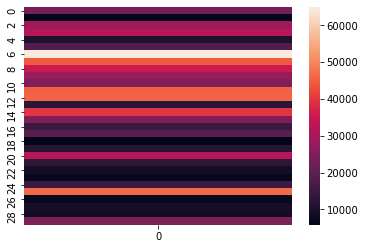

In [11]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [12]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

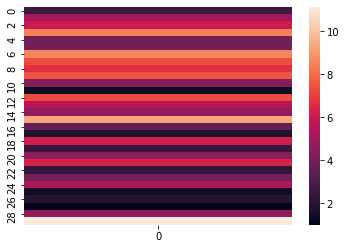

In [13]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

Print out the values to see if our predictions are close.

In [14]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [15]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.0723, 0.2725, 0.1108, 0.2433, 0.2462, 0.2292, 0.0998, 0.2706, 0.0307,
        0.2064, 0.0224, 0.0537, 0.0900, 0.2398, 0.2477, 0.5886, 0.5253, 0.4511,
        0.5892, 0.4499, 0.4474, 0.4963, 0.4496, 0.4943, 0.4809, 0.5092, 0.4741,
        0.5025, 0.4630, 0.5358], device='cuda:0', grad_fn=<SliceBackward>)

In [16]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [17]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0725, 0.1197, 0.1243, 0.0906, 0.1169, 0.0687, 0.1216, 0.0977, 0.0424,
        0.1939, 0.0163, 0.0497, 0.1313, 0.1116, 0.1648, 0.0631, 0.0534, 0.0668,
        0.0727, 0.0661, 0.0594, 0.0592, 0.0667, 0.0611, 0.0626, 0.0836, 0.0849,
        0.0601, 0.0737, 0.0540], device='cuda:0', grad_fn=<SliceBackward>)

Now do the same when the loss is calculated over all the features. We keep all the features non-noisy.

In [18]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel_NInsta(D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [19]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.870155
Train Epoch: 1 [1280/4000 (32%)]	Loss: 19.960140
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.194572
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.370110
====> Epoch: 1 Average loss: 19.5208
====> Test set loss: 18.1819
Train Epoch: 2 [0/4000 (0%)]	Loss: 18.204750
Train Epoch: 2 [1280/4000 (32%)]	Loss: 17.318251
Train Epoch: 2 [2560/4000 (64%)]	Loss: 16.435675
Train Epoch: 2 [3840/4000 (96%)]	Loss: 15.259007
====> Epoch: 2 Average loss: 16.7961
====> Test set loss: 15.0355
Train Epoch: 3 [0/4000 (0%)]	Loss: 15.067239
Train Epoch: 3 [1280/4000 (32%)]	Loss: 14.500895
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.919978
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.610239
====> Epoch: 3 Average loss: 14.2072
====> Test set loss: 13.5598
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.512154
Train Epoch: 4 [1280/4000 (32%)]	Loss: 13.049765
Train Epoch: 4 [2560/4000 (64%)]	Loss: 13.209951
Train Epoch: 4 [3840/4000 (96%)]	Loss: 13.473091
====> Epoch: 4 Average loss: 13.22

Train Epoch: 32 [2560/4000 (64%)]	Loss: 10.778258
Train Epoch: 32 [3840/4000 (96%)]	Loss: 11.354824
====> Epoch: 32 Average loss: 10.9596
====> Test set loss: 10.8758
Train Epoch: 33 [0/4000 (0%)]	Loss: 10.881223
Train Epoch: 33 [1280/4000 (32%)]	Loss: 10.923767
Train Epoch: 33 [2560/4000 (64%)]	Loss: 10.985347
Train Epoch: 33 [3840/4000 (96%)]	Loss: 10.736973
====> Epoch: 33 Average loss: 10.8941
====> Test set loss: 10.8235
Train Epoch: 34 [0/4000 (0%)]	Loss: 10.937256
Train Epoch: 34 [1280/4000 (32%)]	Loss: 11.183161
Train Epoch: 34 [2560/4000 (64%)]	Loss: 10.785748
Train Epoch: 34 [3840/4000 (96%)]	Loss: 10.614501
====> Epoch: 34 Average loss: 10.9001
====> Test set loss: 10.8384
Train Epoch: 35 [0/4000 (0%)]	Loss: 10.642886
Train Epoch: 35 [1280/4000 (32%)]	Loss: 10.946718
Train Epoch: 35 [2560/4000 (64%)]	Loss: 10.899540
Train Epoch: 35 [3840/4000 (96%)]	Loss: 10.947985
====> Epoch: 35 Average loss: 10.8263
====> Test set loss: 10.7475
Train Epoch: 36 [0/4000 (0%)]	Loss: 10.70909

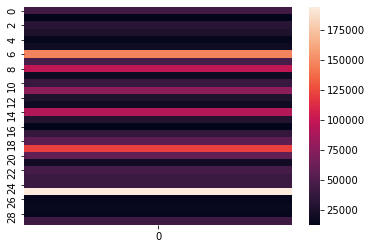

In [20]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [21]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

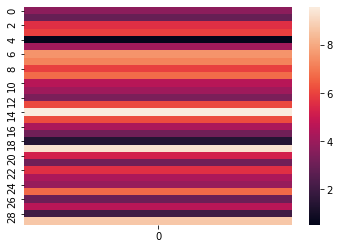

In [22]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [23]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [24]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.0944, 0.3144, 0.1389, 0.2100, 0.2027, 0.2134, 0.1227, 0.2354, 0.0400,
        0.2087, 0.0254, 0.0560, 0.1008, 0.2734, 0.2338, 0.3331, 0.2775, 0.0097,
        0.0353, 0.1003, 0.0863, 0.2600, 0.0072, 0.0267, 0.0039, 0.1069, 0.4745,
        0.3264, 0.2125, 0.2919], device='cuda:0', grad_fn=<SliceBackward>)

Now do it on data where half of the features are just noise.

In [25]:
torch.manual_seed(0)
np.random.seed(0)

In [26]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

actual_data = torch.cat([actual_data, noise_features], dim = 1)

for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))
    
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

tensor(49, device='cuda:0')
tensor(42, device='cuda:0')
tensor(48, device='cuda:0')
tensor(44, device='cuda:0')
tensor(44, device='cuda:0')


Testing how it does when calculating loss over only the non-noisy features. 

In [27]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [28]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.898645
Train Epoch: 1 [1280/4000 (32%)]	Loss: 19.929802
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.052610
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.303110
====> Epoch: 1 Average loss: 19.4577
====> Test set loss: 39.1835
Train Epoch: 2 [0/4000 (0%)]	Loss: 18.139664
Train Epoch: 2 [1280/4000 (32%)]	Loss: 17.451143
Train Epoch: 2 [2560/4000 (64%)]	Loss: 16.215115
Train Epoch: 2 [3840/4000 (96%)]	Loss: 15.406269
====> Epoch: 2 Average loss: 16.7949
====> Test set loss: 36.4903
Train Epoch: 3 [0/4000 (0%)]	Loss: 15.273976
Train Epoch: 3 [1280/4000 (32%)]	Loss: 14.205248
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.512135
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.540610
====> Epoch: 3 Average loss: 14.0477
====> Test set loss: 35.0437
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.251816
Train Epoch: 4 [1280/4000 (32%)]	Loss: 12.921093
Train Epoch: 4 [2560/4000 (64%)]	Loss: 13.159525
Train Epoch: 4 [3840/4000 (96%)]	Loss: 12.858677
====> Epoch: 4 Average loss: 13.11

Train Epoch: 32 [2560/4000 (64%)]	Loss: 11.085241
Train Epoch: 32 [3840/4000 (96%)]	Loss: 11.064404
====> Epoch: 32 Average loss: 11.0010
====> Test set loss: 32.4116
Train Epoch: 33 [0/4000 (0%)]	Loss: 11.369688
Train Epoch: 33 [1280/4000 (32%)]	Loss: 11.212049
Train Epoch: 33 [2560/4000 (64%)]	Loss: 11.255682
Train Epoch: 33 [3840/4000 (96%)]	Loss: 10.907515
====> Epoch: 33 Average loss: 11.0002
====> Test set loss: 32.3624
Train Epoch: 34 [0/4000 (0%)]	Loss: 11.076082
Train Epoch: 34 [1280/4000 (32%)]	Loss: 11.622751
Train Epoch: 34 [2560/4000 (64%)]	Loss: 10.859943
Train Epoch: 34 [3840/4000 (96%)]	Loss: 11.019300
====> Epoch: 34 Average loss: 10.9824
====> Test set loss: 32.3141
Train Epoch: 35 [0/4000 (0%)]	Loss: 10.731936
Train Epoch: 35 [1280/4000 (32%)]	Loss: 10.881388
Train Epoch: 35 [2560/4000 (64%)]	Loss: 10.641421
Train Epoch: 35 [3840/4000 (96%)]	Loss: 11.242130
====> Epoch: 35 Average loss: 10.9390
====> Test set loss: 32.3230
Train Epoch: 36 [0/4000 (0%)]	Loss: 11.24187

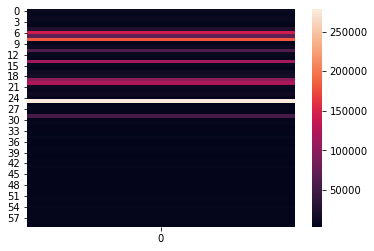

In [29]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [30]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

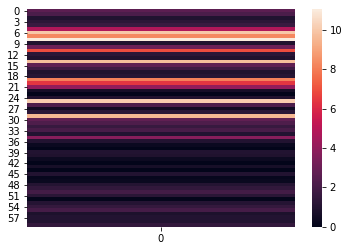

In [31]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [32]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [33]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.0835, 0.2764, 0.1282, 0.2090, 0.2489, 0.2180, 0.0739, 0.2250, 0.0259,
        0.2526, 0.0233, 0.0441, 0.1089, 0.2853, 0.1896, 0.3074, 0.2966, 0.0093,
        0.0312, 0.0836, 0.0766, 0.2295, 0.0061, 0.0239, 0.0037, 0.0596, 0.4819,
        0.3167, 0.2430, 0.3332], device='cuda:0', grad_fn=<SliceBackward>)

In [34]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [35]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.1053, 0.0932, 0.1384, 0.0915, 0.0989, 0.0440, 0.1527, 0.1035, 0.0792,
        0.1206, 0.0272, 0.0562, 0.0662, 0.1167, 0.1647, 0.1512, 0.0543, 0.0120,
        0.0584, 0.1384, 0.0704, 0.1009, 0.0105, 0.0369, 0.0054, 0.1276, 0.0424,
        0.1622, 0.0848, 0.1467], device='cuda:0', grad_fn=<SliceBackward>)

What happens when you calculate the loss over all the features?

In [36]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [37]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.446293
Train Epoch: 1 [1280/4000 (32%)]	Loss: 41.328918
Train Epoch: 1 [2560/4000 (64%)]	Loss: 40.605656
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.730019
====> Epoch: 1 Average loss: 40.9412
====> Test set loss: 39.5725
Train Epoch: 2 [0/4000 (0%)]	Loss: 39.534889
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.611050
Train Epoch: 2 [2560/4000 (64%)]	Loss: 37.899136
Train Epoch: 2 [3840/4000 (96%)]	Loss: 36.834385
====> Epoch: 2 Average loss: 38.3583
====> Test set loss: 36.8626
Train Epoch: 3 [0/4000 (0%)]	Loss: 36.771805
Train Epoch: 3 [1280/4000 (32%)]	Loss: 35.668232
Train Epoch: 3 [2560/4000 (64%)]	Loss: 35.159439
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.249161
====> Epoch: 3 Average loss: 35.3995
====> Test set loss: 34.4142
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.375629
Train Epoch: 4 [1280/4000 (32%)]	Loss: 33.946270
Train Epoch: 4 [2560/4000 (64%)]	Loss: 34.212067
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.694859
====> Epoch: 4 Average loss: 34.11

Train Epoch: 32 [2560/4000 (64%)]	Loss: 31.885035
Train Epoch: 32 [3840/4000 (96%)]	Loss: 31.701113
====> Epoch: 32 Average loss: 31.8344
====> Test set loss: 31.7791
Train Epoch: 33 [0/4000 (0%)]	Loss: 31.740072
Train Epoch: 33 [1280/4000 (32%)]	Loss: 31.768677
Train Epoch: 33 [2560/4000 (64%)]	Loss: 31.612665
Train Epoch: 33 [3840/4000 (96%)]	Loss: 31.807512
====> Epoch: 33 Average loss: 31.8000
====> Test set loss: 31.7884
Train Epoch: 34 [0/4000 (0%)]	Loss: 31.718269
Train Epoch: 34 [1280/4000 (32%)]	Loss: 31.849508
Train Epoch: 34 [2560/4000 (64%)]	Loss: 31.296680
Train Epoch: 34 [3840/4000 (96%)]	Loss: 31.802605
====> Epoch: 34 Average loss: 31.7971
====> Test set loss: 31.7195
Train Epoch: 35 [0/4000 (0%)]	Loss: 31.652014
Train Epoch: 35 [1280/4000 (32%)]	Loss: 31.663940
Train Epoch: 35 [2560/4000 (64%)]	Loss: 31.916801
Train Epoch: 35 [3840/4000 (96%)]	Loss: 31.255962
====> Epoch: 35 Average loss: 31.7636
====> Test set loss: 31.7048
Train Epoch: 36 [0/4000 (0%)]	Loss: 32.04839

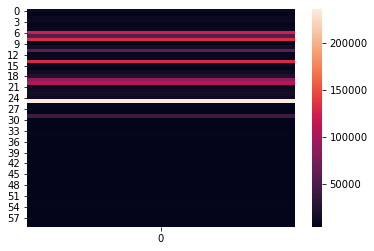

In [38]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [39]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

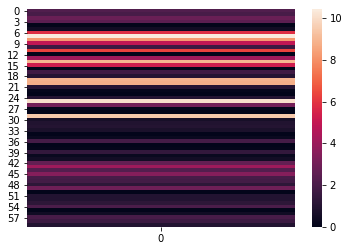

In [40]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [41]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [42]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1120, 0.3104, 0.1491, 0.1965, 0.2159, 0.2077, 0.0917, 0.2180, 0.0381,
        0.2108, 0.0271, 0.0433, 0.0943, 0.2873, 0.1982, 0.3068, 0.2757, 0.0091,
        0.0451, 0.1307, 0.0751, 0.2373, 0.0070, 0.0318, 0.0044, 0.0664, 0.4658,
        0.3474, 0.2159, 0.3015], device='cuda:0', grad_fn=<SliceBackward>)

In [43]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [44]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.1178, 0.0878, 0.1442, 0.1132, 0.1142, 0.0472, 0.1130, 0.1274, 0.0512,
        0.1322, 0.0262, 0.0540, 0.0739, 0.1397, 0.1900, 0.1893, 0.0439, 0.0100,
        0.0546, 0.1632, 0.1115, 0.1045, 0.0093, 0.0342, 0.0057, 0.1189, 0.0575,
        0.1954, 0.0952, 0.1700], device='cuda:0', grad_fn=<SliceBackward>)

It seems that doing the Gumbel trick per batch does make it learn better which features are good. Still less useful than the gradient choosing though. Had to drop the the temperature (but not too much) to get stable, clean-cut heatmaps. Increasing the number of epochs helps.